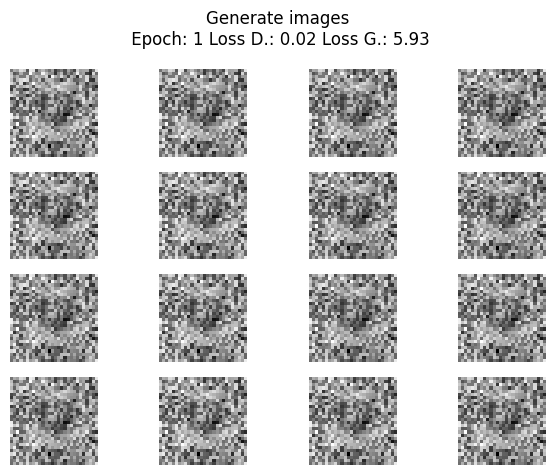

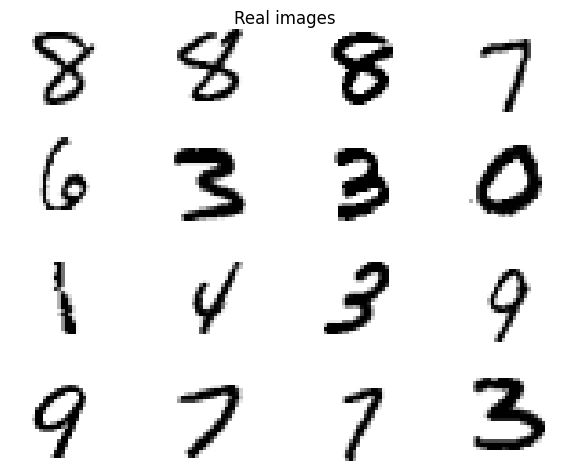

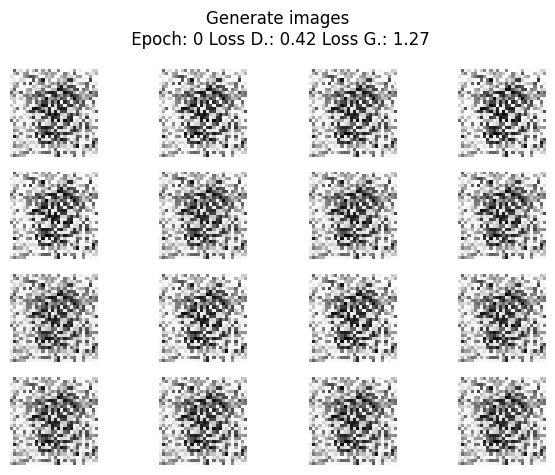

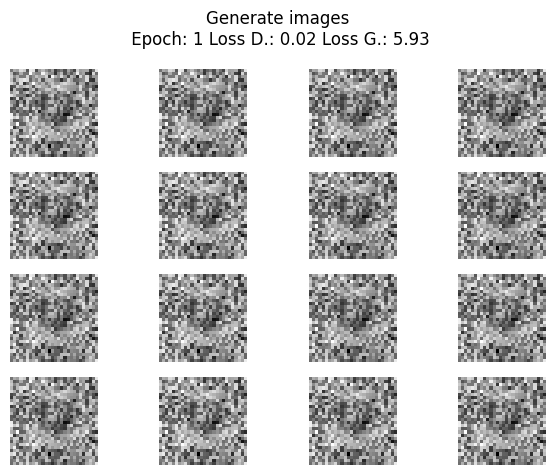

In [1]:
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torchvision
NoneType = type(None)
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import time


# You can copy this code to your personal pipeline project or execute it here.
def train_gan(batch_size: int = 32, num_epochs: int = 100, device: str = "cuda:0" if torch.cuda.is_available() else "cpu"):
    """
    The method trains a Generative Adversarial Network and is based on:
    https://realpython.com/generative-adversarial-networks/

    The Generator network tries to generate convincing images of handwritten digits.
    The Discriminator needs to detect if the image was created by the Generater or if the image is a real image from
    a known dataset (MNIST).
    If both the Generator and the Discriminator are optimized, the Generator is able to create images that are difficult
    to distinguish from real images. This is goal of a GAN.

    This code produces the expected results at first attempt at about 50 epochs.

    :param batch_size: The number of images to train in one epoch.
    :param num_epochs: The number of epochs to train the gan.
    :param device: The computing device to use. If CUDA is installed and working then `cuda:0` is chosen
        otherwise 'cpu' is chosen. Note: Training a GAN on the CPU is very slow.

    **This method is part of a series of debugging exercises.**
    **Each Python method of this series contains bug that needs to be found.**

    It contains at least two bugs: one structural bug and one cosmetic bug. Both bugs are from the original tutorial.

    | ``1   Changing the batch_size from 32 to 64 triggers the structural bug.``
    | ``2   Can you also spot the cosmetic bug?``
    | ``Note: to fix this bug a thorough understanding of GANs is not necessary.``

    Change the batch size to 64 to trigger the bug with message:
    ValueError: "Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size."

    >>> train_gan(batch_size=32, num_epochs=100)
    """
    # Add/adjust code.

    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    try:
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
    except:
        print("Failed to download MNIST, retrying with different URL")
        # see: https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
        torchvision.datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz',
             'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz',
             'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz',
             '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz',
             'ec29112dd5afa0611ce80d1b7f02629c')
        ]
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # example data
    real_samples, mnist_labels = next(iter(train_loader))

    fig = plt.figure()
    for i in range(16):
        sub = fig.add_subplot(4, 4, 1 + i)
        sub.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
        sub.axis('off')

    fig.tight_layout()
    fig.suptitle("Real images")
    display(fig)

    time.sleep(5)

    # Set up training
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)
    lr = 0.0001
    loss_function = nn.BCELoss()
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

    # train
    for epoch in range(num_epochs):
        for n, (real_samples, mnist_labels) in enumerate(train_loader):
            actual_batch_size = real_samples.size(0)

            # Data for training the discriminator
            real_samples = real_samples.to(device=device)
            real_samples_labels = torch.ones((actual_batch_size, 1)).to(device=device)
            latent_space_samples = torch.randn((actual_batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((actual_batch_size, 1)).to(device=device)
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            optimizer_discriminator.step()

            # Data for training the generator
            latent_space_samples = torch.randn((actual_batch_size, 100)).to(device=device)

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            optimizer_generator.step()

            # Show loss and samples generated
            if n == batch_size - 1:
                name = f"Generate images\n Epoch: {epoch} Loss D.: {loss_discriminator:.2f} Loss G.: {loss_generator:.2f}"
                generated_samples = generated_samples.detach().cpu().numpy()
                fig = plt.figure()
                for i in range(16):
                    sub = fig.add_subplot(4, 4, 1 + i)
                    sub.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
                    sub.axis('off')
                fig.suptitle(name)
                fig.tight_layout()
                clear_output(wait=False)
                display(fig)

# You can copy this code to your personal pipeline project or execute it here.
class Discriminator(nn.Module):
    """
    Discriminator class for the GAN
    """
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

# You can copy this code to your personal pipeline project or execute it here.
class Generator(nn.Module):
    """
    Generator class for the GAN
    """

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

train_gan(batch_size=64, num_epochs=100)
